In [3]:
import math
from itertools import combinations


In [4]:
def L(x, y, p=2):
    # x1 = [1, 1], x2 = [5,1]
    if len(x) == len(y) and len(x) > 1:
        sum = 0
        for i in range(len(x)):
            # 函数pow为对第一个参数取第二个参数次方
            sum += math.pow(abs(x[i] - y[i]), p)
        return math.pow(sum, 1 / p)
    else:
        return 0


In [6]:
x1 = [1, 1]
x2 = [5, 1]
x3 = [4, 4]
# 循环求x1 和 x3的1-5范数
for i in range(1, 5):
    # 注意这种字典的表示
    r = {'1-{}'.format(c): L(x1, c, p=i) for c in [x2, x3]}
    print(r)

{'1-[5, 1]': 4.0, '1-[4, 4]': 6.0}
{'1-[5, 1]': 4.0, '1-[4, 4]': 4.242640687119285}
{'1-[5, 1]': 3.9999999999999996, '1-[4, 4]': 3.7797631496846193}
{'1-[5, 1]': 4.0, '1-[4, 4]': 3.5676213450081633}


python实现，遍历所有数据点，找出$n$个距离最近的点的分类情况，少数服从多数

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from collections import Counter


In [12]:
iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['label'] = iris.target
df.columns = ['sepal length', 'sepal width', 'petal length', 'petal width', 'label']
# data = np.array(df.iloc[:100, [0, 1, -1]])
df

,sepal length,sepal width,petal length,petal width,label
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


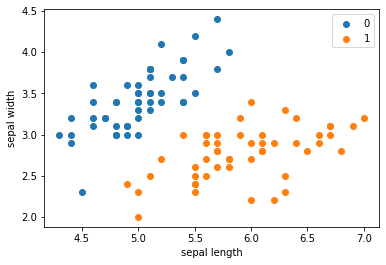

In [13]:
plt.scatter(df[:50]['sepal length'], df[:50]['sepal width'], label='0')
plt.scatter(df[50:100]['sepal length'], df[50:100]['sepal width'], label='1')
plt.xlabel('sepal length')
plt.ylabel('sepal width')
plt.legend()


In [20]:
data = np.array(df.iloc[:100, [0, 1, -1]])
data, label = data[:, :-1], data[:, -1]
# 利用sklearn，以0.2的数量分割出训练集和测试集，自动打乱
data_train, data_test, label_train, label_test = train_test_split(data, label, test_size=0.2)

In [21]:
class KNN:
    def __init__(self, X_train, y_train, n_neighbors=3, p=2):
        """
        parameter: n_neighbors 临近点个数
        parameter: p 距离度量
        """
        self.n = n_neighbors
        self.p = p
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X):
        # 取出n个点
        knn_list = []
        # 对前n个点与输入的测试集的数据求范数得到距离，并放进列表里
        for i in range(self.n):
            # 计算范数
            dist = np.linalg.norm(X - self.X_train[i], ord=self.p)
            knn_list.append((dist, self.y_train[i]))
        # 上一个for比较了n个元素，这个for把训练集剩下的元素全部拿进去计算范数比较
        for i in range(self.n, len(self.X_train)):
            # knn_list是一个序列，中间的元素均为二维，key参数指定以元素中的第一个作为比较大小的对象，取出其中最大的一个元素，再取下标
            max_index = knn_list.index(max(knn_list, key=lambda x: x[0]))
            dist = np.linalg.norm(X - self.X_train[i], ord=self.p)
            # 如果剩下的元素里与输入的测试数据的距离小于前三个数据的最大值的，就把新的距离替换进去
            if knn_list[max_index][0] > dist:
                knn_list[max_index] = (dist, self.y_train[i])
        # 到这一步完成就陆陆续续的得到了最近的n个点

        # 统计其标签,全部存进knn序列
        knn = [k[-1] for k in knn_list]
        # 统计序列中0或者1或者2的个数
        count_pairs = Counter(knn)
#         max_count = sorted(count_pairs, key=lambda x: x)[-1]
        # 把统计好的词典作为一个序列存进新的序列max_count,其中每个元素是二维的
        # 这里存储参数key意味着按照一个匿名函数来降序存储，即按照输入的二维元素第二个（数量）来排列储存
        # 这样取出最后一个元素即为最大投票额的标签的键值对，取出第一个就是标签
        max_count = sorted(count_pairs.items(), key=lambda x: x[1])[-1][0]
        return max_count

    def score(self, X_test, y_test):
        right_count = 0
        n = 10
        # 把测试集数据一个一个的拿进去进行距离判定，测量与训练集各元素的距离，并统计得分得到标签判定
        for X, y in zip(X_test, y_test):
            label = self.predict(X)
            # 判定正确+1分，最后得到测试正确率
            if label == y:
                right_count += 1
        return right_count / len(X_test)

In [41]:
clf = KNN(data_train, label_train)
clf.score(data_test, label_test)


1.0

In [42]:
# 随便放入一个点，看看预测结果是多少
test_point = [6.0, 3.0]
print('Test Point: {}'.format(clf.predict(test_point)))

Test Point: 1.0


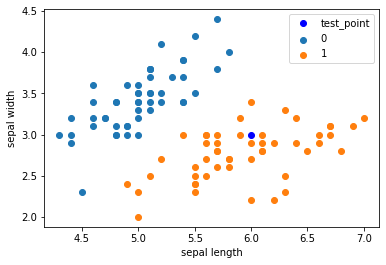

In [43]:
plt.scatter(df[:50]['sepal length'], df[:50]['sepal width'], label='0')
plt.scatter(df[50:100]['sepal length'], df[50:100]['sepal width'], label='1')
plt.plot(test_point[0], test_point[1], 'bo', label='test_point')
plt.xlabel('sepal length')
plt.ylabel('sepal width')
plt.legend()
# 还是比较可以的

In [44]:
# 通过sklearn使用KNN
from sklearn.neighbors import KNeighborsClassifier


In [45]:
clf_sk = KNeighborsClassifier()
clf_sk.fit(data_train, label_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [46]:
# 训练完毕，开始测试得分：
clf_sk.score(data_test, label_test)


1.0

In [47]:
# kd-tree每个结点中主要包含的数据结构如下
class KdNode(object):
    def __init__(self, dom_elt, split, left, right):
        self.dom_elt = dom_elt  # k维向量节点(k维空间中的一个样本点)
        self.split = split  # 整数（进行分割维度的序号）
        self.left = left  # 该结点分割超平面左子空间构成的kd-tree
        self.right = right  # 该结点分割超平面右子空间构成的kd-tree


In [79]:
class KdTree(object):
    def __init__(self, data):
        """
        构建kd树，传入的数据为data，为一组数据
        :param data: 构建树的k维数据，其中行数为数据数量，列数为维数
        """
        k = len(data[0])  # 获取数据维数
        def CreateKdTree(split, data_set):
            # 结束条件为数据集拆分至空
            if not data_set:
                return None
            # key参数的值为一个函数，此函数只有一个参数且返回一个值用来进行比较
            # 这里把data_set按照用于求中位数的一维数据（一列）排序
            data_set.sort(key=lambda x: x[split])
            # 求中位数，split为切分的维数
            split_pos = len(data_set) // 2 # python整数除法
            media = data_set[split_pos] # 中位数位置数组
            split_next = (split+1) % k

            return KdNode(
                media,
                split,
                CreateKdTree(split_next, data_set[:split_pos]),
                CreateKdTree(split_next, data_set[split_pos+1:])
            )
        self.root = CreateKdTree(0, data)

    def GetTree(self):
        return self.root

# 前序遍历
def preorder(root):
    print(root.dom_elt)
    if root.left:  # 节点不为空
        preorder(root.left)
    if root.right:
        preorder(root.right)

In [80]:
# 对构建好的kd树进行搜索，寻找与目标点最近的样本点：
from math import sqrt
from collections import namedtuple

# 定义一个namedtuple,分别存放最近坐标点、最近距离和访问过的节点数
result = namedtuple('Result_tuple',
                    ['nearest_point',  'nearest_dist',  'nodes_visited'])
result._fields

('nearest_point', 'nearest_dist', 'nodes_visited')

In [81]:
def find_nearest(tree, point):
    k = len(point)  # 数据维度

    def travel(kd_node, target, max_dist):
        if kd_node is None:
            return result([0] * k, float("inf"),
                          0)  # python中用float("inf")和float("-inf")表示正负无穷,同时返回一个全0的k维数组

        nodes_visited = 1

        s = kd_node.split  # 进行分割的维度
        pivot = kd_node.dom_elt  # 进行分割的“轴”，即该数据以上为左子树，以下为右子树

        if target[s] <= pivot[s]:  # 如果目标点第s维小于分割轴的对应值(目标离左子树更近)
            nearer_node = kd_node.left  # 下一个访问节点为左子树根节点
            further_node = kd_node.right  # 同时记录下右子树
        else:  # 目标离右子树更近
            nearer_node = kd_node.right  # 下一个访问节点为右子树根节点
            further_node = kd_node.left

        temp1 = travel(nearer_node, target, max_dist)  # 进行遍历找到包含目标点的区域

        nearest = temp1.nearest_point  # 以此叶结点作为“当前最近点”
        dist = temp1.nearest_dist  # 更新最近距离

        nodes_visited += temp1.nodes_visited

        if dist < max_dist:
            max_dist = dist  # 最近点将在以目标点为球心，max_dist为半径的超球体内

        temp_dist = abs(pivot[s] - target[s])  # 第s维上目标点与分割超平面的距离
        if max_dist < temp_dist:  # 判断超球体是否与超平面相交
            return result(nearest, dist, nodes_visited)  # 不相交则可以直接返回，不用继续判断

        #----------------------------------------------------------------------
        # 计算目标点与分割点的欧氏距离
        temp_dist = sqrt(sum((p1 - p2)**2 for p1, p2 in zip(pivot, target)))

        if temp_dist < dist:  # 如果“更近”
            nearest = pivot  # 更新最近点
            dist = temp_dist  # 更新最近距离
            max_dist = dist  # 更新超球体半径

        # 检查另一个子结点对应的区域是否有更近的点
        temp2 = travel(further_node, target, max_dist)

        nodes_visited += temp2.nodes_visited
        if temp2.nearest_dist < dist:  # 如果另一个子结点内存在更近距离
            nearest = temp2.nearest_point  # 更新最近点
            dist = temp2.nearest_dist  # 更新最近距离

        return result(nearest, dist, nodes_visited)

    return travel(tree.root, point, float("inf"))  # 从根节点开始递归

In [82]:
data = [[2,3],[5,4],[9,6],[4,7],[8,1],[7,2]]
kd = KdTree(data)
preorder(kd.root)

[7, 2]
[5, 4]
[2, 3]
[4, 7]
[9, 6]
[8, 1]


In [83]:
from time import clock
from random import random

# 产生一个k维随机向量，每维分量值在0~1之间
def random_point(k):
    return [random() for _ in range(k)]

# 产生n个k维随机向量
def random_points(k, n):
    return [random_point(k) for _ in range(n)]


In [85]:
ret = find_nearest(kd, [3,4.5])
print (ret)


Result_tuple(nearest_point=[2, 3], nearest_dist=1.8027756377319946, nodes_visited=4)


In [86]:
N = 400000
t0 = clock()
kd2 = KdTree(random_points(3, N))            # 构建包含四十万个3维空间样本点的kd树
ret2 = find_nearest(kd2, [0.1,0.5,0.8])      # 四十万个样本点中寻找离目标最近的点
t1 = clock()
print ("time: ",t1-t0, "s")
print (ret2)


/Users/shenheng/anaconda3/envs/Py/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/Users/shenheng/anaconda3/envs/Py/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """


time:  3.8134060000000005 s
Result_tuple(nearest_point=[0.10051092316115795, 0.5109501707502493, 0.8048444324238924], nearest_dist=0.011984815703459186, nodes_visited=98)


习题3.1
    参照图3.1，在二维空间中给出实例点，画出$k$为1和2时的$k$近邻法构成的空间划分，并对其进行比较，体会$k$值选择与模型复杂度及预测准确率的关系。



In [87]:
%matplotlib inline
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

data = np.array([[5, 12, 1], [6, 21, 0], [14, 5, 0], [16, 10, 0], [13, 19, 0],
                 [13, 32, 1], [17, 27, 1], [18, 24, 1], [20, 20,
                                                         0], [23, 14, 1],
                 [23, 25, 1], [23, 31, 1], [26, 8, 0], [30, 17, 1],
                 [30, 26, 1], [34, 8, 0], [34, 19, 1], [37, 28, 1]])
X_train = data[:, 0:2]
y_train = data[:, 2]

models = (KNeighborsClassifier(n_neighbors=1, n_jobs=-1),
          KNeighborsClassifier(n_neighbors=2, n_jobs=-1))
models = (clf.fit(X_train, y_train) for clf in models)


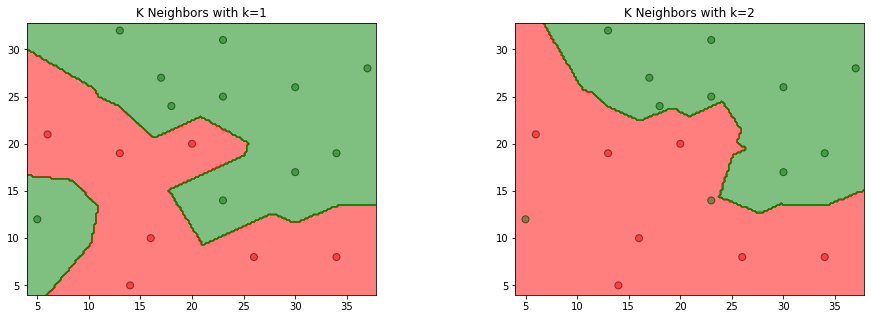

In [88]:
titles = ('K Neighbors with k=1', 'K Neighbors with k=2')

fig = plt.figure(figsize=(15, 5))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

X0, X1 = X_train[:, 0], X_train[:, 1]

x_min, x_max = X0.min() - 1, X0.max() + 1
y_min, y_max = X1.min() - 1, X1.max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.2),
                     np.arange(y_min, y_max, 0.2))

for clf, title, ax in zip(models, titles, fig.subplots(1, 2).flatten()):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    colors = ('red', 'green', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(Z))])
    ax.contourf(xx, yy, Z, cmap=cmap, alpha=0.5)
    ax.scatter(X0, X1, c=y_train, s=50, edgecolors='k', cmap=cmap, alpha=0.5)
    ax.set_title(title)

plt.show()
